In [43]:
import pandas as pd
import time
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import kernelml
import datetime
from sklearn import preprocessing
from scipy import signal
import tensorflow as tf

full=pd.read_csv("DATA/daily-minimum-temperatures-in-me.csv")
full['Date']=[datetime.datetime.strptime(t[0],"%m/%d/%y") for t in full[['Date']].values]
full.sort_values(by='Date',inplace=True)

In [44]:
def replace_with_nan(x):
    if '?' in x:
        return np.nan
    else:
        return float(x)
full.Temp = full.Temp.apply(lambda x: replace_with_nan(str(x)))

In [45]:
def interpolate_nans(y):
    def nan_helper(y):
        return np.isnan(y), lambda z: z.nonzero()[0]
    nans, x = nan_helper(y)
    y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    return y

full.loc[:,'Temp'] = interpolate_nans(full['Temp'])

/Users/rohankotwani/anaconda/envs/datasci/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [46]:
train_percentage = 0.8

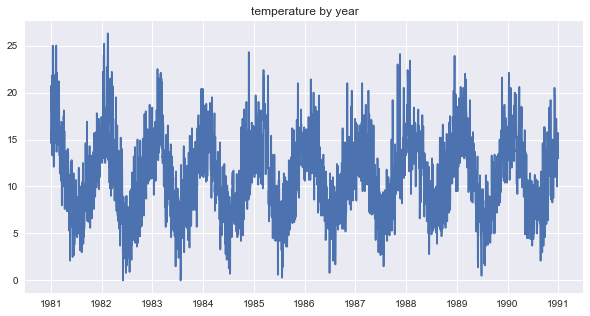

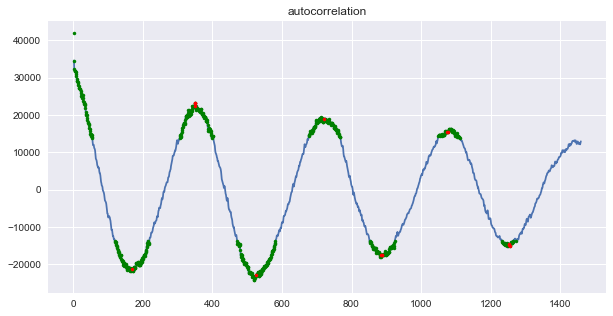

autocorrelation
[ 168  349  350  351  524  721  885  887  888 1075 1078 1252 1253 1254]


In [47]:
y = full[['Temp']].values[:int(len(full)*train_percentage)]
plt.figure(figsize=(10,5))
plt.plot(full[['Date']].values,full[['Temp']].values)
plt.title('temperature by year')
plt.show()

def autocorrelation(x):
    result = np.correlate(x, x, mode='same')
    result = result[result.size//2:]
    return result

def derivative(x):
    x = np.convolve(x,[-1,0,1],mode='full')
    x = x[1:-1]
    return x

def integral(x,w=50):
    x = np.convolve(x,np.ones(w)/w,mode='full')
    x = x[w//2:-w//2+1] 
    return x

ac = autocorrelation(y.ravel())
ac = signal.detrend(ac)
t = np.arange(0,ac.size)

ac = ac[1:]
t = t[1:]

d = derivative(integral(ac))
peaks = np.where(np.abs(d)<8)[0]
strong_corr = np.where(np.abs(ac)>np.mean(ac)+np.std(ac))[0]
plt.figure(figsize=(10,5))
plt.plot(t[1:],ac[1:])
plt.plot(t[strong_corr],ac[strong_corr],'g.')
plt.plot(t[peaks],ac[peaks],'r.')
plt.title('autocorrelation')
plt.show()
print('autocorrelation')
print(t[peaks])

autocorrelation_peaks = t[strong_corr]

In [48]:
# indices = np.concatenate((periodicity_peaks,autocorrelation_peaks)).astype(np.int)
indices = autocorrelation_peaks.astype(np.int)
indices = indices[indices<400]
mask = np.zeros(400).astype(np.bool) #np.ones_like(a,dtype=bool)
mask[indices] = True


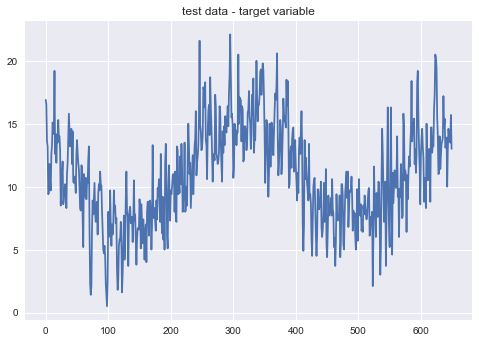

[]

In [49]:
lag = 400

def create_permutation(size):
    return np.random.permutation(size)

def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)

    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def create_train_test(data,percentage,permutation):
    c = int(data.shape[0] * percentage)
    data_train = data[0:c]
    shuffled_train = np.empty(data_train.shape)
    for old_index, new_index in enumerate(permutation):
        shuffled_train[new_index] = data_train[old_index]
    data_test = data[c:]
    return shuffled_train,data_test


def split_into_chunks(data,lag):
    result = np.zeros((data.shape[0]-lag,lag))
    for i in range(lag,data.shape[0]):
        result[i-lag] = data[i-lag:i].ravel()
    return result


y = full[['Temp']].values[lag:]


X = split_into_chunks(full[['Temp']].values,lag)
X = X[:,mask]


perm = create_permutation(int(y.size * 0.8))

y_train, y_test = create_train_test(y,percentage=0.8,permutation=perm)

X_train, X_test = create_train_test(X,percentage=0.8,permutation=perm)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)


plt.plot(y_test)
plt.title('test data - target variable')
plt.show()
plt.plot()

In [50]:
hidden_layer_1 = 1

weights_1 = tf.Variable(
                    tf.random_normal((X_train.shape[1],hidden_layer_1),
                    stddev=0.01,dtype='float32')
                    )



b1 = tf.Variable(tf.zeros((1,hidden_layer_1),dtype='float32'))

input_X = tf.placeholder('float32',(None,X.shape[1]))
input_y = tf.placeholder('float32',(None,1))

predicted_out = tf.add(tf.matmul(input_X,weights_1),tf.reduce_sum(b1*weights_1))

loss = tf.reduce_sum(tf.square(predicted_out-input_y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(loss)

s = tf.Session()
s.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=None)


batchsize = int(X.shape[0]*0.5)

In [51]:
for epoch in range(1000):
    rand_sample = np.random.choice(X_train.shape[0],size=batchsize,replace=False)
    X_batch = X_train[rand_sample]
    y_batch = y_train[rand_sample]
    for i in range(X_batch.shape[0]):
        s.run(optimizer,feed_dict={input_X:X_batch[i:i+1],input_y:y_batch[i:i+1]})
    saver.save(s,'autoregmodel/model',global_step=epoch)

INFO:tensorflow:autoregmodel/model-0 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-1 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-2 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-3 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-4 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-5 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-6 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-7 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-8 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-9 is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:autoregmodel/model-10 is not in al

In [52]:
def predict_time_series(y,num_models,num_epochs):
    ts = np.zeros((num_models,y.shape[0]))
    j=0
    for epoch in range(num_epochs-num_models,num_epochs):
        saver.restore(s,'autoregmodel/model-'+str(epoch))
        predicted = np.zeros((y.shape[0],1))
        predicted[:lag] = y[:lag]
        for i in range(lag,y.shape[0]):
            pred = s.run(predicted_out,{input_X:y[i-lag:i][mask].T})
            predicted[i] = pred
        ts[j] = predicted.flatten()
        j+=1
        plt.plot(predicted[:])
    plt.show()
    return ts

In [53]:
def create_snowballed_time_series(y,num_models,num_epochs):
    ts = np.zeros((num_models,y.shape[0]))
    j=0
    for epoch in range(num_epochs-num_models,num_epochs):
        saver.restore(s,'autoregmodel/model-'+str(epoch))
        predicted = np.zeros((y.shape[0],1))
        predicted[:lag] = y[:lag]
        for i in range(lag,y.shape[0]):
            pred = s.run(predicted_out,{input_X:predicted[i-lag:i][mask].T})
            predicted[i] = pred
        ts[j] = predicted.flatten()
        j+=1
        plt.plot(predicted[:])
    plt.show()
    return ts

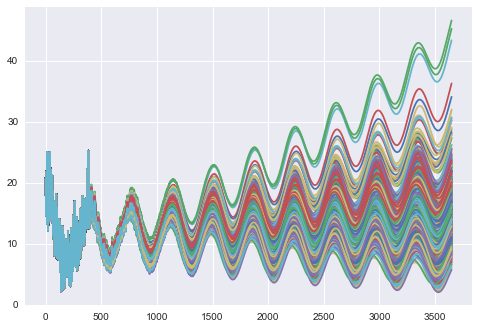

In [54]:
num_epochs = 20
Y_full = full[['Temp']].values[:]
full_ts = create_snowballed_time_series(Y_full,num_models=900,num_epochs=1000)

In [55]:
errors =  (full_ts[:] - Y_full.T).T

In [56]:
np.sum(np.mean(errors,axis=0)<0),np.sum(np.mean(errors,axis=0)>=0)

(305, 595)

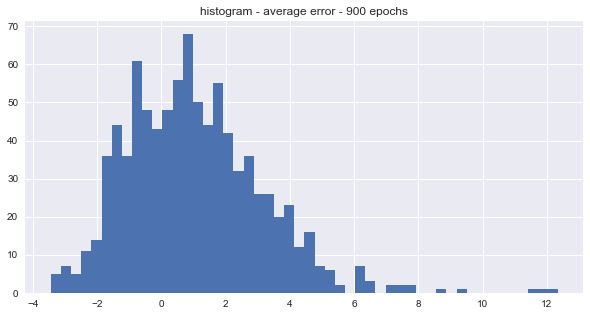

In [57]:
plt.figure(figsize=(10,5))
plt.hist(np.mean(errors,axis=0),bins=50)
plt.title("histogram - average error - 900 epochs")
plt.show()

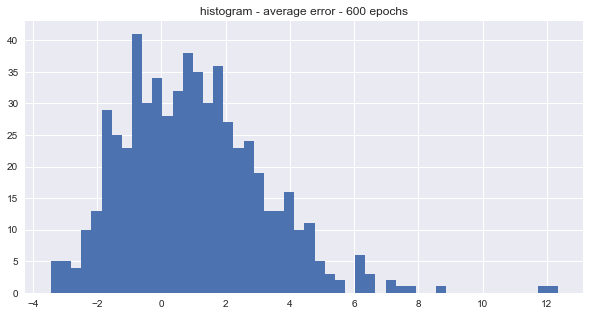

In [58]:
plt.figure(figsize=(10,5))
plt.hist(np.mean(errors,axis=0)[300:],bins=50)
plt.title("histogram - average error - 600 epochs")
plt.show()

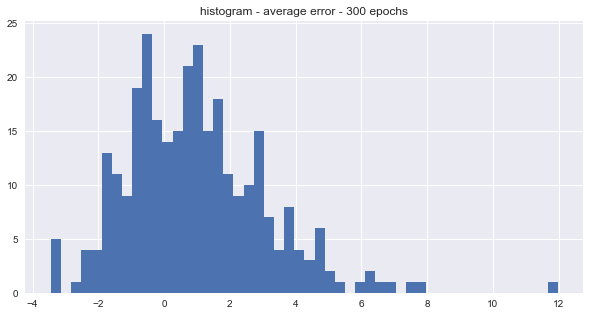

In [59]:
plt.figure(figsize=(10,5))
plt.hist(np.mean(errors,axis=0)[600:],bins=50)
plt.title("histogram - average error - 300 epochs")
plt.show()

In [60]:
start = np.max(indices)

def sb_sse(yp,y,start):
    sse = np.mean((y[start:,0] - np.mean(yp[:,start:],axis=0)-z*np.std(yp[:,start:],axis=0))**2)
    return sse

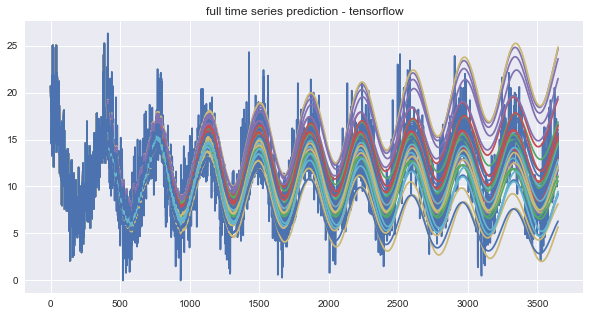

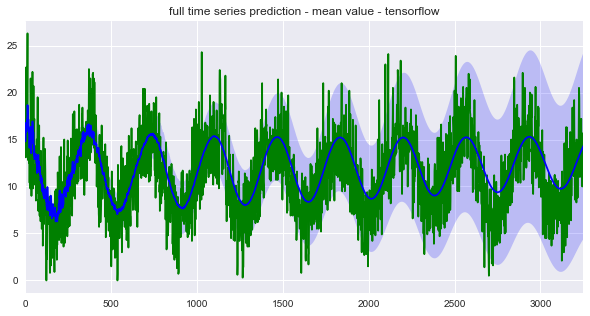

rsquared: -3.24438522608 std from mean -3
rsquared: -1.02710696592 std from mean -2
rsquared: 0.208055882742 std from mean -1
rsquared: 0.461103319912 std from mean 0
rsquared: -0.267964654411 std from mean 1
rsquared: -1.97914804023 std from mean 2
rsquared: -4.67244683754 std from mean 3


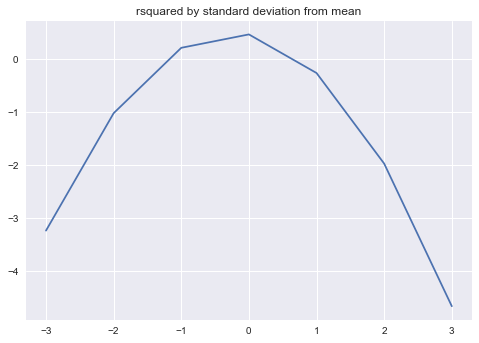

In [61]:
Y_full = full[['Temp']].values[:]

plt.figure(figsize=(10,5))
plt.plot(Y_full)
plt.title('full time series prediction - tensorflow')
sb_full = create_snowballed_time_series(Y_full,num_models=30,num_epochs=1000)


plt.figure(figsize=(10,5))
plt.title('full time series prediction - mean value - tensorflow')
plt.plot(Y_full[start:],'g')
ci_ts = np.array([np.mean(sb_full,axis=0)+2*np.std(sb_full,axis=0),
                np.mean(sb_full,axis=0),
                np.mean(sb_full,axis=0)-2*np.std(sb_full,axis=0)])
sns.tsplot(ci_ts[:,start:],color='blue',estimator=np.median,err_style='ci_band',ci=[95])
plt.show()

x = np.arange(-3,4,1)
rsq = np.zeros(7)
i=0
for z in np.arange(-3,4,1):
    SSE = sb_sse(sb_full,Y_full,start)
    SST = np.mean((Y_full[start:,0] - np.mean(Y_full[start:,0]))**2)
    print('rsquared:',1-SSE/SST,'std from mean',z)
    rsq[i] = 1-SSE/SST
    i+=1
    
plt.plot(x,rsq)
plt.title('rsquared by standard deviation from mean')
plt.show()

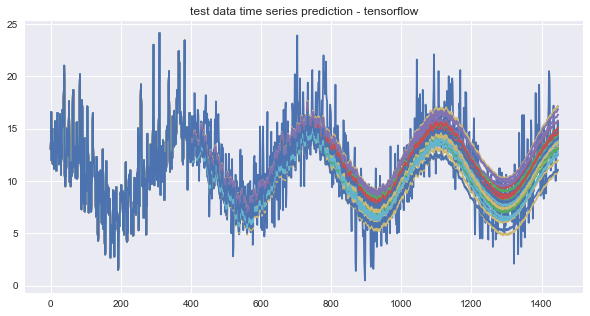

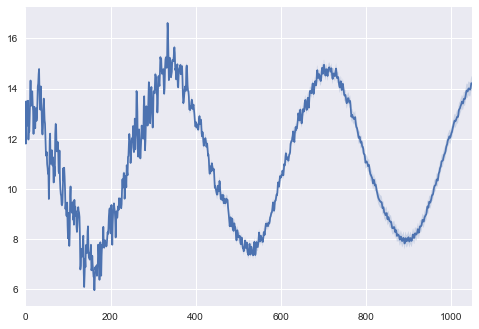

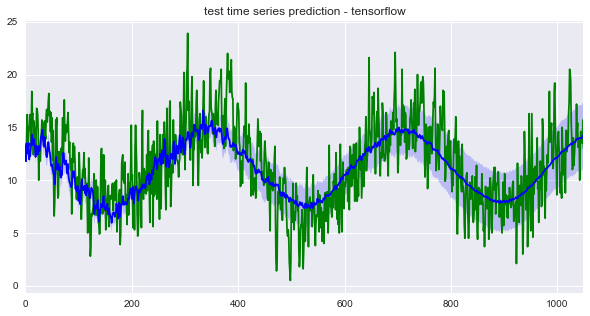

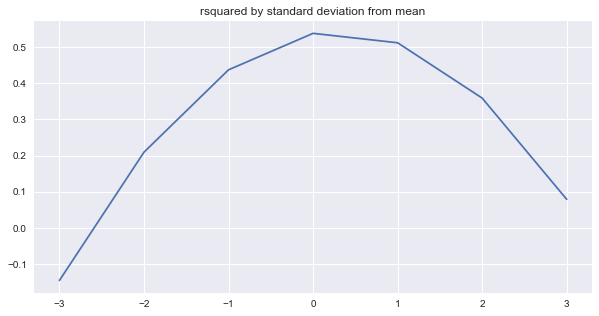

In [62]:

Y_valid = full[['Temp']].values[X_train.shape[0]-start:]

plt.figure(figsize=(10,5))
plt.plot(Y_valid)
plt.title('test data time series prediction - tensorflow')
sb_valid = create_snowballed_time_series(Y_valid,num_models=30,num_epochs=1000)
    
sns.tsplot(sb_valid[:,start:])
plt.show()

plt.figure(figsize=(10,5))
plt.title('test time series prediction - tensorflow')
plt.plot(Y_valid[start:],'g')
cis = np.array([np.mean(sb_valid,axis=0)+2*np.std(sb_valid,axis=0),np.mean(sb_valid,axis=0),np.mean(sb_valid,axis=0)-2*np.std(sb_valid,axis=0)])
sns.tsplot(cis[:,start:],color='blue',estimator=np.median,err_style='ci_band',ci=[95])
plt.show()

x = np.arange(-3,4,1)
rsq = np.zeros(7)
i=0
for z in np.arange(-3,4,1):
    SSE = sb_sse(sb_valid,Y_valid,start)
    SST = np.mean((Y_valid[start:,0] - np.mean(Y_valid[start:,0]))**2)
    rsq[i] = 1-SSE/SST
    i+=1

plt.figure(figsize=(10,5))
plt.title('rsquared by standard deviation from mean')
plt.plot(x,rsq)
plt.show()

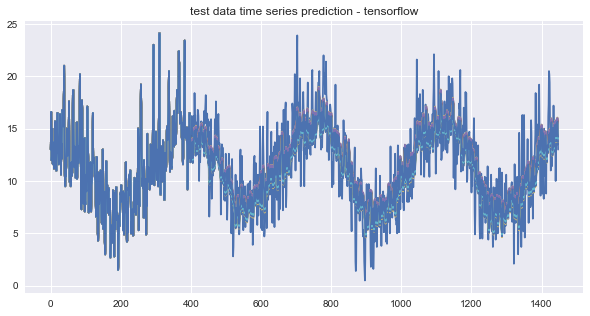

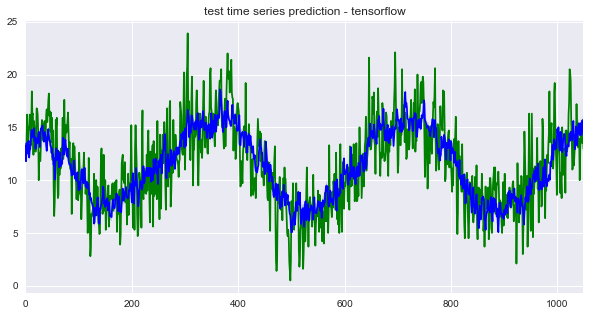

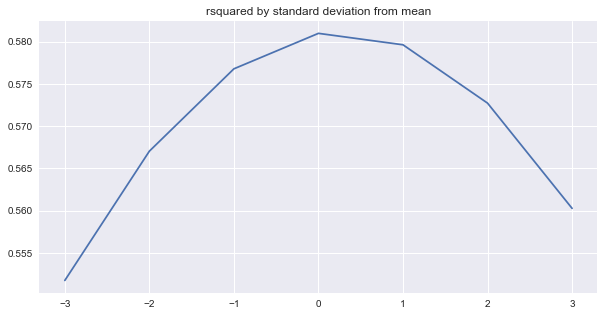

In [63]:

start = np.max(indices)
Y_valid = full[['Temp']].values[X_train.shape[0]-start:]

plt.figure(figsize=(10,5))
plt.plot(Y_valid)
plt.title('test data time series prediction - tensorflow')
sb_valid = predict_time_series(Y_valid,num_models=30,num_epochs=1000)

plt.figure(figsize=(10,5))
plt.title('test time series prediction - tensorflow')
plt.plot(Y_valid[start:],'g')
cis = np.array([np.mean(sb_valid,axis=0)+2*np.std(sb_valid,axis=0),np.mean(sb_valid,axis=0),np.mean(sb_valid,axis=0)-2*np.std(sb_valid,axis=0)])
sns.tsplot(cis[:,start:],color='blue',estimator=np.median,err_style='ci_band',ci=[95])
plt.show()

x = np.arange(-3,4,1)
rsq = np.zeros(7)
i=0
for z in np.arange(-3,4,1):
    SSE = sb_sse(sb_valid,Y_valid,start)
    SST = np.mean((Y_valid[start:,0] - np.mean(Y_valid[start:,0]))**2)
    rsq[i] = 1-SSE/SST
    i+=1

plt.figure(figsize=(10,5))
plt.title('rsquared by standard deviation from mean')
plt.plot(x,rsq)
plt.show()